In [1]:
#matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)



('2017-08-23',)


In [11]:
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(one_year_ago)

2016-08-23


In [12]:
# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(query,columns=['date', 'precipitation'])

precipitation_df.tail()


,date,precipitation
2225,2017-08-19,0.09
2226,2017-08-20,NaN
2227,2017-08-21,0.56
2228,2017-08-22,0.50
2229,2017-08-23,0.45


In [13]:
# Change datatype from element to datetime object on Pandas
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'], format='%Y-%m-%d')

# Set index to date
precipitation_df.set_index('date', inplace=True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date',ascending=True)
precipitation_df.tail(1)

,precipitation
date,
2017-08-23,0.45


<Figure size 360x288 with 0 Axes>

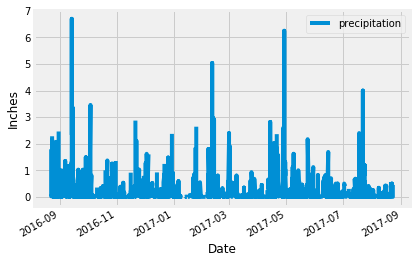

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data

fig1 = plt.figure(figsize=(5,4))
precipitation_df.plot()
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend()
plt.savefig("Images/Precipitation.png")
plt.show()

![precipitation](Images/precipitation.png)

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df['precipitation'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

![describe](Images/describe.png)

In [16]:
# Design a query to show how many stations are available in this dataset?
Stations =session.query(Measurement).group_by(Measurement.station).count()
Stations
print("There are {} available stations in the dataset.".format(Stations))

There are 9 available stations in the dataset.


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
active = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).all()
#select column
observation = active[0][0]



In [18]:
#List stations and count in descending order
print("-----------------")
print("The most active station is",observation,"and contains",active[0][1],"observations.")
print("-----------------")
print("This is a list of the most active stations, displayed in descending order:")
for station, count in active:
    print("this station id:",station,"has this many weather observations:",count,)

-----------------
The most active station is USC00519281 and contains 2772 observations.
-----------------
This is a list of the most active stations, displayed in descending order:
this station id: USC00519281 has this many weather observations: 2772
this station id: USC00519397 has this many weather observations: 2724
this station id: USC00513117 has this many weather observations: 2709
this station id: USC00519523 has this many weather observations: 2669
this station id: USC00516128 has this many weather observations: 2612
this station id: USC00514830 has this many weather observations: 2202
this station id: USC00511918 has this many weather observations: 1979
this station id: USC00517948 has this many weather observations: 1372
this station id: USC00518838 has this many weather observations: 511


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_stats = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station == observation)
print(f"Most Active Station Temperatures:")
print(f"Low: {temp_stats[0][1]} High: {temp_stats[0][2]} Average: {round(temp_stats[0][3], 5)}")

Most Active Station Temperatures:
Low: 54.0 High: 85.0 Average: 71.66378


In [20]:
# Choose the station with the highest number of temperature observations.

histo = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).first()
#select column
observation = active[0][0]

In [21]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_observations = session.query(Measurement.tobs).filter(Measurement.date >= one_year_ago).filter(Measurement.station == observation).all()
temps = pd.DataFrame(temperature_observations, columns=['temperature'])
temps.head()


,temperature
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


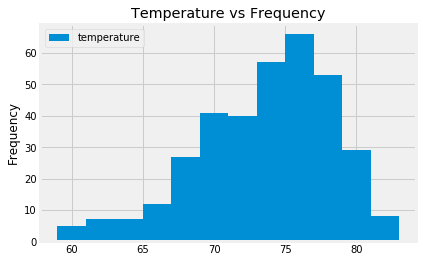

In [22]:
#create histogram
temps.plot.hist(bins=12,title="Temperature vs Frequency")
plt.tight_layout
plt.savefig("Images/TemperaturevsFrequency.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2016-08-23','2017-08-23')
trip

[(58.0, 74.59058295964125, 87.0)]

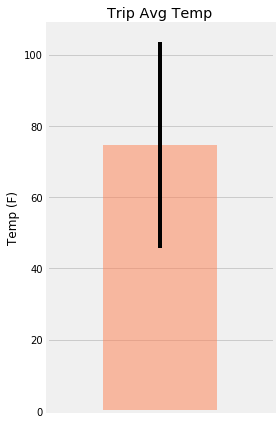

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temps = pd.DataFrame(trip, columns=['tmin','tavg','tmax'])
trip_temps


trip_temps.plot.bar(y='tavg', yerr=(trip_temps['tmax'] - trip_temps['tmin']), title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images/TripAvgTemp.png")
plt.show()


In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):
    
        # Docstring for the function `calc_temps`
    """Precipitation information per weather station
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        A list of tuples containing precipitation amount, station, name, latitude, longitude, and elevation in descending order.
    """
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(precipitation('2016-08-23','2017-08-23'))    




[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.79), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.7), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.15), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.05), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.02), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


## Optional Challenge Assignment

In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-14'

# Use the start and end date to create a range of dates
date_range = session.query(Measurement.date).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
group_by(Measurement.date).all() 

trip_dates = [x[0] for x in date_range]

# Stip off the year and save a list of %m-%d strings
trip_dates_stripped = [x[5:] for x in trip_dates]

# Find the start month/day and the end month/day 
start_month_day = trip_dates_stripped[0]
end_month_day = trip_dates_stripped[-1]

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals = [session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs),func.max(Measurement.tobs)).\
                 filter(func.strftime("%m-%d",Measurement.date) >= start_month_day).\
                filter(func.strftime("%m-%d",Measurement.date) <= end_month_day).group_by(func.strftime("%m-%d",Measurement.date)).all()]

daily_normals = daily_normals[0]
print("Aggregate Daily Normals for 07-01 to 07-14")
daily_normals

Aggregate Daily Normals for 07-01 to 07-14


[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0),
 (68.0, 76.5576923076923, 83.0),
 (69.0, 75.98039215686275, 81.0),
 (65.0, 76.42, 83.0),
 (67.0, 75.98113207547169, 82.0),
 (67.0, 76.52727272727273, 83.0),
 (71.0, 76.98245614035088, 84.0),
 (71.0, 76.77777777777777, 82.0)]

In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df =pd.DataFrame(daily_normals,columns=['tmin','tavg','tmax'])
daily_normals_df['date']=trip_dates

#Change datatype from element to datetime object on Pandas, makes x axis title to add 
daily_normals_df['date'] = pd.to_datetime(daily_normals_df['date'],format='%Y-%m-%d')

# Set index to date
daily_normals_df.set_index('date',inplace=True)

daily_normals_df

,tmin,tavg,tmax
date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0
2017-08-08,68.0,76.557692,83.0
2017-08-09,69.0,75.980392,81.0


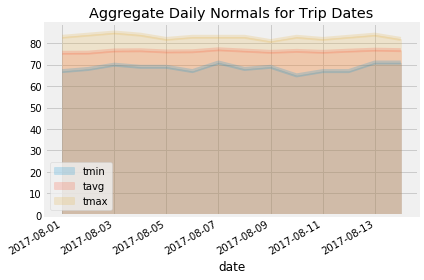

In [30]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind='area', alpha = .2, stacked = False, x_compat = True,title="Aggregate Daily Normals for Trip Dates")
plt.tight_layout()
plt.savefig("Images/DailyNormals.png")
plt.show()